<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-02-13 18:48:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-02-13 18:48:33 (11.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

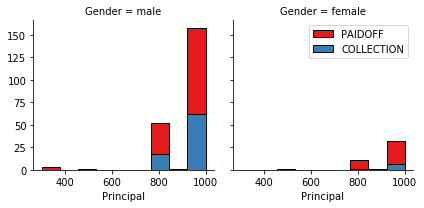

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

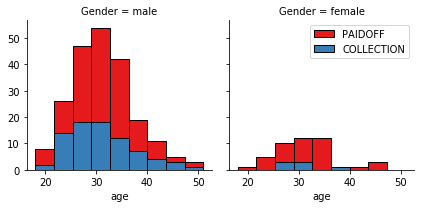

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

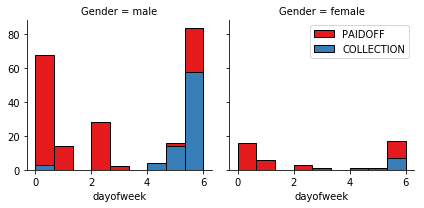

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X = Feature.values.astype(float)
X[0:5]

array([[ 1000.,    30.,    45.,     0.,     0.,     0.,     1.,     0.],
       [ 1000.,    30.,    33.,     1.,     0.,     1.,     0.,     0.],
       [ 1000.,    15.,    27.,     0.,     0.,     0.,     0.,     1.],
       [ 1000.,    30.,    28.,     1.,     1.,     0.,     0.,     1.],
       [ 1000.,    30.,    29.,     0.,     1.,     0.,     0.,     1.]])

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  

**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.


In [20]:
from sklearn.model_selection import train_test_split
X_KNN_train, X_KNN_test, y_KNN_train, y_KNN_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_KNN_train.shape,  y_KNN_train.shape)
print ('Test set:', X_KNN_test.shape,  y_KNN_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_KNN_train,y_KNN_train)
    yhat_KNN=neigh.predict(X_KNN_test)
    mean_acc[n-1] = metrics.accuracy_score(y_KNN_test, yhat_KNN)
    std_acc[n-1]=np.std(yhat_KNN==y_KNN_test)/np.sqrt(yhat_KNN.shape[0])

mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286,  0.67142857,
        0.7       ,  0.72857143,  0.7       ,  0.7       ])

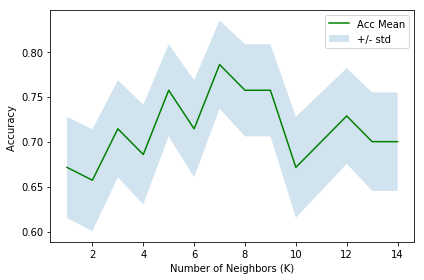

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.2)
plt.legend(('Acc Mean', '+/- std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import jaccard_similarity_score

k = 7 #Number of Neighbors  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_KNN_train,y_KNN_train)
yhat_KNN = neigh.predict(X_KNN_test)

print("Train set initial Jaccard Score: ", jaccard_similarity_score(y_KNN_train, neigh.predict(X_KNN_train)))
print("Test set initial Jaccard Score: ", jaccard_similarity_score(y_KNN_test, yhat_KNN))
Result_KNN_J = jaccard_similarity_score(y_KNN_train, neigh.predict(X_KNN_train))

Train set initial Jaccard Score:  0.807971014493
Test set initial Jaccard Score:  0.785714285714


In [24]:
from sklearn.metrics import f1_score
print("Train set initial F1 Score: ", f1_score(y_KNN_train, neigh.predict(X_KNN_train), average='weighted'))
print("Test set initial F1 Score: ", f1_score(y_KNN_test, yhat_KNN, average='weighted'))
Result_KNN_F = f1_score(y_KNN_train, neigh.predict(X_KNN_train), average='weighted')

Train set initial F1 Score:  0.800019466876
Test set initial F1 Score:  0.776654024442


#### Answer 1 : The optimal K is 7. The initial accuracy for sets are above.
*******

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_Dec_train, X_Dec_test, y_Dec_train, y_Dec_test = train_test_split(X, y, test_size=0.3, random_state=3)
DecTree = DecisionTreeClassifier(class_weight=None, max_depth=None, max_features=None, max_leaf_nodes=None,
 min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
 presort=False, random_state=None)
DecTree.fit(X_Dec_train,y_Dec_train)
yhat_Dec = DecTree.predict(X_Dec_test)

print ('Train set:', X_Dec_train.shape,  y_Dec_train.shape)
print ('Test set:', X_Dec_test.shape,  y_Dec_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


In [26]:
from sklearn.metrics import jaccard_similarity_score
print("Train set initial Jaccard Score: ", jaccard_similarity_score(y_Dec_train, DecTree.predict(X_Dec_train)))
print("Test set initial Jaccard Score: ", jaccard_similarity_score(y_Dec_test, yhat_Dec))
Result_Dec_J = jaccard_similarity_score(y_Dec_train, DecTree.predict(X_Dec_train))

Train set initial Jaccard Score:  0.929752066116
Test set initial Jaccard Score:  0.653846153846


In [27]:
from sklearn.metrics import f1_score
print("Train set initial F1 Score: ", f1_score(y_Dec_train, DecTree.predict(X_Dec_train), average='weighted'))
print("Test set initial F1 Score: ", f1_score(y_Dec_test, yhat_Dec, average='weighted'))
Result_Dec_F = f1_score(y_Dec_train, DecTree.predict(X_Dec_train), average='weighted')

Train set initial F1 Score:  0.931355687977
Test set initial F1 Score:  0.661167108753


# Support Vector Machine

In [28]:
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn import svm

X_SVM_train, X_SVM_test, y_SVM_train, y_SVM_test = train_test_split( X, y, test_size=0.25, random_state=4)
clf = svm.SVC(kernel='rbf')
clf.fit(X_SVM_train, y_SVM_train)
yhat_SVM = clf.predict(X_SVM_test)

print ('Train set:', X_SVM_train.shape, y_SVM_train.shape)
print ('Test set:', X_SVM_test.shape, y_SVM_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


In [29]:
from sklearn.metrics import jaccard_similarity_score
print("Train set initial Jaccard Score: ", jaccard_similarity_score(y_SVM_train, clf.predict(X_SVM_train)))
print("Test set initial Jaccard Score: ", jaccard_similarity_score(y_SVM_test, yhat_SVM))
Result_SVM_J = jaccard_similarity_score(y_SVM_train, clf.predict(X_SVM_train))

Train set initial Jaccard Score:  0.760617760618
Test set initial Jaccard Score:  0.747126436782


In [30]:
from sklearn.metrics import f1_score
print("Train set initial F1 Score: ", f1_score(y_SVM_train, clf.predict(X_SVM_train), average='weighted'))
print("Test set initial F1 Score: ", f1_score(y_SVM_test, yhat_SVM, average='weighted'))
Result_SVM_F = f1_score(y_SVM_train, clf.predict(X_SVM_train), average='weighted')

Train set initial F1 Score:  0.661012471723
Test set initial F1 Score:  0.649770114943


# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_LogReg_train, X_LogReg_test, y_LogReg_train, y_LogReg_test = train_test_split(X, y, test_size=0.2, random_state=4)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_LogReg_train,y_LogReg_train)
yhat_LogReg = LR.predict(X_LogReg_test)
yhat_LogReg_prob = LR.predict_proba(X_LogReg_test)

print ('Train set:', X_LogReg_train.shape, y_LogReg_train.shape)
print ('Test set:', X_LogReg_test.shape, y_LogReg_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [32]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_LogReg_test, yhat_LogReg)

print("Train set initial Jaccard Score: ", jaccard_similarity_score(y_LogReg_train, LR.predict(X_LogReg_train)))
print("Test set initial Jaccard Score: ", jaccard_similarity_score(y_LogReg_test, yhat_LogReg))
Result_LogReg_J = jaccard_similarity_score(y_LogReg_train, LR.predict(X_LogReg_train))

Train set initial Jaccard Score:  0.757246376812
Test set initial Jaccard Score:  0.685714285714


In [33]:
from sklearn.metrics import f1_score
print("Train set initial F1 Score: ", f1_score(y_LogReg_train, LR.predict(X_LogReg_train), average='weighted'))
print("Test set initial F1 Score: ", f1_score(y_LogReg_test, yhat_LogReg, average='weighted'))
Result_LogReg_F = f1_score(y_LogReg_train, LR.predict(X_LogReg_train), average='weighted')

Train set initial F1 Score:  0.734114633775
Test set initial F1 Score:  0.667052246


In [34]:
from sklearn.metrics import log_loss
print("Train set Log Loss: ", log_loss(y_LogReg_train, LR.predict_proba(X_LogReg_train)))
print("Test set Log Loss: ", log_loss(y_LogReg_test, yhat_LogReg_prob))
Result_LogReg_L = log_loss(y_LogReg_train, LR.predict_proba(X_LogReg_train))

Train set Log Loss:  0.551396631518
Test set Log Loss:  0.577228760948


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-02-13 18:48:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-02-13 18:48:36 (473 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.shape

(54, 10)

In [38]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [40]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [41]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [42]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

X_test = Feature_test
X_test = Feature_test.values.astype(float)

#y_test = test_df['loan_status'].values
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [43]:
print(test_df.shape)
test_df.head()

(54, 12)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [44]:
print(df.shape)
df.head()

(346, 12)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [45]:
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1, inplace=True)

X2 = Feature2
X2 = Feature2.values.astype(float)
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)

y2 = test_df['loan_status'].values

In [46]:
X[:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [47]:
X2[:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [48]:
y[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [49]:
y2[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

**We checked that have similar dataframes. Now we can test our models.**

In [50]:
yhat2_KNN = neigh.predict(X2)
print("Test set KNN Jaccard Score: ", jaccard_similarity_score(y2, yhat2_KNN))
print("Test set KNN F1 Score: ", f1_score(y2, yhat2_KNN, average='weighted'))
FinalResult_KNN_J = jaccard_similarity_score(y2, yhat2_KNN)
FinalResult_KNN_F = f1_score(y2, yhat2_KNN, average='weighted')

Test set KNN Jaccard Score:  0.666666666667
Test set KNN F1 Score:  0.632840028189


In [51]:
yhat2_Dec = DecTree.predict(X2)
print("Test set Decision Tree Jaccard Score: ", jaccard_similarity_score(y2, yhat2_Dec))
print("Test set Decision Tree F1 Score: ", f1_score(y2, yhat2_Dec, average='weighted'))
FinalResult_Dec_J = jaccard_similarity_score(y2, yhat2_Dec)
FinalResult_Dec_F = f1_score(y2, yhat2_Dec, average='weighted')

Test set Decision Tree Jaccard Score:  0.648148148148
Test set Decision Tree F1 Score:  0.643804298125


In [52]:
yhat2_SVM = clf.predict(X2)
print("Test set SVM Jaccard Score: ", jaccard_similarity_score(y2, yhat2_SVM))
print("Test set SVM F1 Score: ", f1_score(y2, yhat2_SVM, average='weighted'))
FinalResult_SVM_J = jaccard_similarity_score(y2, yhat2_SVM)
FinalResult_SVM_F = f1_score(y2, yhat2_SVM, average='weighted')

Test set SVM Jaccard Score:  0.740740740741
Test set SVM F1 Score:  0.630417651694


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
yhat2_LogReg = LR.predict(X2)
yhat2_LogReg_prob = LR.predict_proba(X2)
print("Test set Logistic Regression Jaccard Score: ", jaccard_similarity_score(y2, yhat2_LogReg))
print("Test set Logistic Regression F1 Score: ", f1_score(y2, yhat2_LogReg, average='weighted'))
print("Test set Logistic Regression Log Loss: ", log_loss(y2, yhat2_LogReg_prob))
FinalResult_LogReg_J = jaccard_similarity_score(y2, yhat2_LogReg)
FinalResult_LogReg_F = f1_score(y2, yhat2_LogReg, average='weighted')
FinalResult_LogReg_L = log_loss(y2, yhat2_LogReg_prob)

Test set Logistic Regression Jaccard Score:  0.740740740741
Test set Logistic Regression F1 Score:  0.660426731079
Test set Logistic Regression Log Loss:  0.567215337991


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [54]:
print("\t","\t","\t","Training Scores:\t Test Scores:\n",\
"\n",\
"KNN\t","- Jaccard\t",Result_KNN_J,"\t",FinalResult_KNN_J,"\n",\
"\t","- F1 Score\t",Result_KNN_F,"\t",FinalResult_KNN_F,"\n",\
"\n",\
"Dec Tre","- Jaccard\t",Result_Dec_J,"\t",FinalResult_Dec_J,"\n",\
"\t","- F1 Score\t",Result_Dec_F,"\t",FinalResult_Dec_F,"\n",\
"\n",\
"SVM\t","- Jaccard\t",Result_SVM_J,"\t",FinalResult_SVM_J,"\n",\
"\t","- F1 Score\t",Result_SVM_F,"\t",FinalResult_SVM_F,"\n",\
"\n",\
"Log Reg","- Jaccard\t",Result_LogReg_J,"\t",FinalResult_LogReg_J,"\n",\
"\t","- F1 Score\t",Result_LogReg_F,"\t",FinalResult_LogReg_F,"\n",\
"\t","- LogLoss\t",Result_LogReg_L,"\t",FinalResult_LogReg_L,"\n",\
"\n")

	 	 	 Training Scores:	 Test Scores:
 
 KNN	 - Jaccard	 0.807971014493 	 0.666666666667 
 	 - F1 Score	 0.800019466876 	 0.632840028189 
 
 Dec Tre - Jaccard	 0.929752066116 	 0.648148148148 
 	 - F1 Score	 0.931355687977 	 0.643804298125 
 
 SVM	 - Jaccard	 0.760617760618 	 0.740740740741 
 	 - F1 Score	 0.661012471723 	 0.630417651694 
 
 Log Reg - Jaccard	 0.757246376812 	 0.740740740741 
 	 - F1 Score	 0.734114633775 	 0.660426731079 
 	 - LogLoss	 0.551396631518 	 0.567215337991 
 



| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66    | 0.63     | NA      |
| Decision Tree      | 0.62    | 0.63     | NA      |
| SVM                | 0.74    | 0.63     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.56    |

There is a substential difference between training results and final test results.
There may be an overfitting on Decision Tree training process.
SVM and Logistic Regression has the (same) highest score on test data. 